### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [64]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import corner


data = np.load("/home/shwetha/repos/ASTR_3300_S2025/coursework/homeworks/hw_data/hw3_data_1.npy")

# Question 1
x, dx= data[:,0], data[:,1]
weights = 1/dx**2

w_mean = np.sum(weights*x)/np.sum(weights)
std_err = np.sqrt(1/np.sum(weights))

print("Weighted Mean:", w_mean)
print("Standard Error:", std_err)

Weighted Mean: 3.917992034606056
Standard Error: 0.09481084100510954


In [54]:
# Question 2

mu1 = np.mean(x)

def log_L(w_mean, x, std_err):
    return 0.5*np.sum(((x-w_mean)**2)/std_err**2)

result = minimize(lambda mu: log_L(mu, x, dx),x0=[mu1])

print("Best-fit mean:", result.x[0])

Best-fit mean: 3.9179920230537464


In [55]:
# Question 3

Fisher_uncertainty = np.sqrt(1 /(np.sum(1/dx**2)))
print("Fisher cuncertainty:", Fisher_uncertainty)

Fisher cuncertainty: 0.09481084100510954


In [62]:
# Question 4

def bootstrap_resample(data, n_bootstrap=1000):
    N = len(data)
    bootstrap_means = np.zeros(n_bootstrap)

    for i in range(n_bootstrap):
        resample_indices = np.random.randint(0, N, N)
        resampled_data = data[resample_indices]  # Select new sample

        x_resampled = resampled_data[:, 0]
        sigma_resampled = resampled_data[:, 1]

        weights = 1 / sigma_resampled**2

        bootstrap_means[i] = np.sum(weights * x_resampled) / np.sum(weights)

    return bootstrap_means

bootstrap_means = bootstrap_resample(data, n_bootstrap=1000)

bootstrap_uncertainty = np.std(bootstrap_means)

# Print results
print("Bootstrap mean estimate:", np.mean(bootstrap_means))
print("Bootstrap uncertainty estimate:", bootstrap_uncertainty)


Bootstrap mean estimate: 3.9122547767970453
Bootstrap uncertainty estimate: 0.09127667952657825


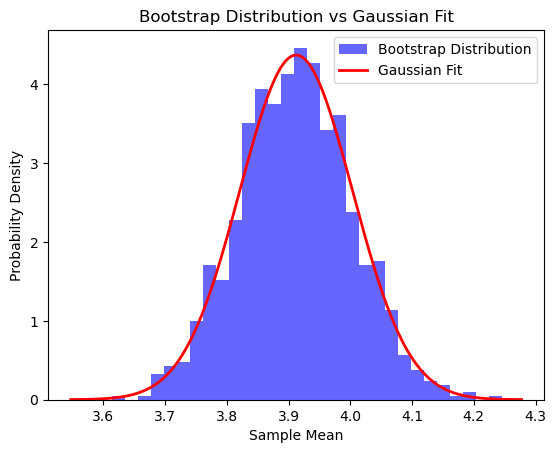

In [67]:
# Question 5

import matplotlib.pyplot as plt
from scipy.stats import norm

bootstrap_mean = np.mean(bootstrap_means)
bootstrap_std = np.std(bootstrap_means)

xmin = bootstrap_mean-4*bootstrap_std
xmax = bootstrap_mean+4*bootstrap_std

x_values = np.linspace(xmin, xmax, 1000)
gaussian_pdf = norm.pdf(x_values, loc=bootstrap_mean, scale=bootstrap_std)


plt.hist(bootstrap_means, bins=30, density=True, alpha=0.6, color='b', label='Bootstrap Distribution')
plt.plot(x_values, gaussian_pdf, 'r-', lw=2, label='Gaussian Fit')

plt.xlabel("Sample Mean")
plt.ylabel("Probability Density")
plt.title("Bootstrap Distribution vs Gaussian Fit")
plt.legend()
plt.show()


In [87]:
#Question 6

def log_L_laplace(par, x, sigma):
    mu, Delta = par
    Delta_i = np.sqrt(Delta**2+sigma**2)
    return np.sum(np.log(2*Delta_i)+np.abs(x-mu)/Delta_i)


mu_initial = np.median(data[:, 0])
Delta_initial = np.std(data[:, 0])
result = minimize(lambda par: log_L_laplace(par, data[:, 0], data[:, 1]), x0=[mu_initial, Delta_initial])
best_fit_mu, best_fit_Delta = result.x

print("Best-fit Laplace location parameter (mu):", best_fit_mu)
print("Best-fit Laplace scale parameter (Delta):", best_fit_Delta)


Best-fit Laplace location parameter (mu): 4.042947694259333
Best-fit Laplace scale parameter (Delta): -1.810625313636921e-05


In [85]:
#Question 7

k = 1 # assuming only 1 parameter
best_fit_mu_gaussian = w_mean

def log_L_gauss(mu, x, sigma):
    return -0.5*np.sum(((x-mu)**2)/sigma**2 + np.log(2*np.pi*sigma**2))



logL_gaussian = log_L_gauss(best_fit_mu_gaussian, data[:, 0], data[:, 1])

AIC_gaussian = (2*k)-(2*logL_gaussian) 

def log_L_lap(mu, Delta, x, sigma):
    Delta_i = np.sqrt(Delta**2+sigma**2)
    return np.sum(-np.log(2*Delta_i)-np.abs(x-mu)/Delta_i)

# Compute log-likelihood for Laplace
logL_laplace = log_L_lap(best_fit_mu, best_fit_Delta, data[:, 0], data[:, 1])


AIC_laplace = (2*k)-(2*logL_laplace) 


print("AIC for Gaussian model:", AIC_gaussian)
print("AIC for Laplace model:", AIC_laplace)


if AIC_gaussian < AIC_laplace:
    print("The Gaussian model is favored.")
else:
    print("The Laplacian model is favored.")


AIC for Gaussian model: 296.5157257746175
AIC for Laplace model: 316.4032317798625
The Gaussian model is favored.


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_501372/2412284187.py:13: SyntaxWarning: invalid escape sequence '\m'
  figure = corner.corner(BS_par, labels=["$\mu$", "$\Delta$"],quantiles=[0.16, 0.5, 0.84],show_titles=True)
/tmp/ipykernel_501372/2412284187.py:13: SyntaxWarning: invalid escape sequence '\D'
  figure = corner.corner(BS_par, labels=["$\mu$", "$\Delta$"],quantiles=[0.16, 0.5, 0.84],show_titles=True)


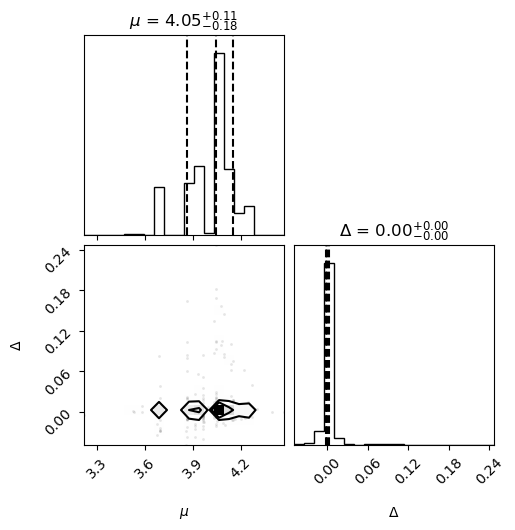

In [107]:
BS_par = np.zeros((1000, 2))
N = len(data)


for i in range(1000):
    resample_indices = np.random.randint(0,N,N)
    resampled_data = data[resample_indices]
    x_resampled, sigma_resampled = resampled_data[:, 0], resampled_data[:, 1]
    result = minimize(lambda params: log_L_laplace(params, x_resampled, sigma_resampled), x0=[np.median(x_resampled), np.std(x_resampled)])
    BS_par[i, :] = result.x

#corner plot
figure = corner.corner(BS_par, labels=["$\mu$", "$\Delta$"],quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()


In [2]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution